<a href="https://colab.research.google.com/github/HealLink/ML-Model/blob/ryan's-experiment/notebook_bert_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow[and-cuda]
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [ ]:
!pip3 install tf_keras==2.18
!pip3 install --upgrade tensorflow-hub

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [11]:
# Import-import
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import json
import random

tf.get_logger().setLevel('ERROR')

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [6]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Step 1: Data cleaning

In [ ]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

In [ ]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [ ]:
df.head()

In [ ]:
df.info()

### Step 1a: Basic cleaning

In [ ]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

In [ ]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [ ]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

### Step 1b: Deep cleaning

In [ ]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [ ]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
def clean_text(text):
    text = text.lower()
    # remove stopwords
    for word in stopwords:
        if word[0] == "'":
            text = re.sub(rf"{word}\b", "", text)
        else:
            text = re.sub(rf"\b{word}\b", "", text)

    text = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', text) # remove punctuation mark
    # text = re.sub(emoj, ' ', text) # remove emoji
    text = re.sub(r'\d+', ' ', text) # remove number
    # text = re.sub(r'(.)\1+', r'\1', text) # remove repeated character
    # text = re.sub(r' [a-z] ', ' ', text) # remove single character
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [ ]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [ ]:
# Data distribution analysis of each label
df.status.value_counts()

In [ ]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [ ]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [ ]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

In [ ]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

In [ ]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 256)].reset_index(drop=True)
df_export_candidate.status.value_counts()

In [ ]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

In [ ]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

In [ ]:
df_export_candidate.status.value_counts()

In [ ]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [ ]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data_10-256_removed_stopwords_punc_num_space.csv', index=False)

In [ ]:
del df
del df_export_candidate

# Step 2: Create the model

In [7]:
VOCAB_SIZE = 10000
MAX_LENGTH = 256
TRAINING_SPLIT = 0.8
BATCH_SIZE = 4
SEED = 69

In [28]:
suicidal = []
stress = []
personality_disorder = []
normal = []
depression = []
bipolar = []
anxiety = []

with open(data_dir+'/cleaned_data_10-256_removed_stopwords_punc_num_space.csv', 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        label = row[1]
        sentence = row[0]
        if label == 'Suicidal':
            suicidal.append(sentence)
        elif label == 'Stress':
            stress.append(sentence)
        elif label == 'Personality disorder':
            personality_disorder.append(sentence)
        elif label == 'Normal':
            normal.append(sentence)
        elif label == 'Depression':
            depression.append(sentence)
        elif label == 'Bipolar':
            bipolar.append(sentence)
        else:
            anxiety.append(sentence)

random.shuffle(suicidal)
random.shuffle(stress)
random.shuffle(personality_disorder)
random.shuffle(normal)
random.shuffle(depression)
random.shuffle(bipolar)
random.shuffle(anxiety)

print(f"There're {len(suicidal)} suicidal")
print(f"There're {len(stress)} stress")
print(f"There're {len(personality_disorder)} personality_disorder")
print(f"There're {len(normal)} normal")
print(f"There're {len(depression)} depression")
print(f"There're {len(bipolar)} bipolar")
print(f"There're {len(anxiety)} anxiety")

# dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

There're 831 suicidal
There're 831 stress
There're 831 personality_disorder
There're 831 normal
There're 831 depression
There're 831 bipolar
There're 831 anxiety


### Step 2a: Create tf.data.Dataset

In [30]:
train_size = int(len(suicidal + stress + personality_disorder + normal + depression + bipolar + anxiety) * TRAINING_SPLIT)
train_size_per_label = int(train_size / 7)

sentences_train = suicidal[:train_size_per_label] + stress[:train_size_per_label] + personality_disorder[:train_size_per_label] + normal[:train_size_per_label] + depression[:train_size_per_label] + bipolar[:train_size_per_label] + anxiety[:train_size_per_label]
labels_train = ['Suicidal' for i in range(train_size_per_label)] + ['Stress' for i in range(train_size_per_label)] + ['Personality disorder' for i in range(train_size_per_label)] + ['Normal' for i in range(train_size_per_label)] + ['Depression' for i in range(train_size_per_label)] + ['Bipolar' for i in range(train_size_per_label)] + ['Anxiety' for i in range(train_size_per_label)]

sentences_val = suicidal[train_size_per_label:] + stress[train_size_per_label:] + personality_disorder[train_size_per_label:] + normal[train_size_per_label:] + depression[train_size_per_label:] + bipolar[train_size_per_label:] + anxiety[train_size_per_label:]
labels_val = ['Suicidal' for i in range(831-train_size_per_label)] + ['Stress' for i in range(831-train_size_per_label)] + ['Personality disorder' for i in range(831-train_size_per_label)] + ['Normal' for i in range(831-train_size_per_label)] + ['Depression' for i in range(831-train_size_per_label)] + ['Bipolar' for i in range(831-train_size_per_label)] + ['Anxiety' for i in range(831-train_size_per_label)]

train_dataset = tf.data.Dataset.from_tensor_slices((sentences_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((sentences_val, labels_val))

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.")
print(f"There are {val_dataset.cardinality()} sentence-label pairs for validation.")


There are 4648 sentence-label pairs for training.
There are 1169 sentence-label pairs for validation.


In [27]:
train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = val_dataset.map(lambda statement, status: statement)
test_labels = val_dataset.map(lambda statement, status: status)

In [31]:
del suicidal
del stress
del personality_disorder
del normal
del depression
del bipolar
del anxiety

del sentences_train
del sentences_val
del labels_train
del labels_val

### Step 2b: Create label encoder

In [32]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.

    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)

    return label_encoder

# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


### Step 2c: Dataset preprocessing

In [33]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_label_encoded = tf.data.Dataset.zip(train_statement,train_labels_encoded)
test_dataset_label_encoded = tf.data.Dataset.zip(test_statement,test_labels_encoded)

# print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
# print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

In [34]:
# del train_dataset_label_encoded
# del test_dataset_label_encoded
del train_labels_encoded
del test_labels_encoded

In [ ]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

### Step 2d: Architect the model

#### Step 2d-1: Loading model - choose model to fine tune

In [35]:
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Step 2d-2: Preprocessing model

In [36]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['i wanna die']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1045 10587  3280   102     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Step 2d-3: Using BERT Model

In [37]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


In [38]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


#### Step 2d-4: Defining model

In [39]:
def make_bert_preprocess_model(sentence_features, seq_length=512):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [40]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

In [41]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 512)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 512)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 512)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [58]:
classifier_model = build_classifier_model(7)
bert_raw_result = classifier_model(text_preprocessed)

print(f'Shape of the output: {bert_raw_result.shape}')
print(tf.nn.softmax(bert_raw_result))

Shape of the output: (1, 7)
tf.Tensor(
[[0.06244007 0.16644494 0.13659106 0.38998154 0.06399195 0.08184098
  0.09870946]], shape=(1, 7), dtype=float32)


In [59]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_dataset_final).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps #int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [60]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# STEP IDK: tokenizing data

In [43]:
for statement, label in train_dataset_label_encoded.take(1):
    print(statement)
    print(label)

tf.Tensor(b'thought posting not got better now back actually make post guessi know grateful everything id like think every time think near future just months even cannot handle thought living never wanted live old cannot handle not know life stopped bothering trying decide cannot even bring care put effort feels certain however going die will hands even ten years future ten days work school not working summer given much alone time think everyone know moving lives refuse grow something life things passionate past month lost interest motivation try think stuff stay alive like taking care pets waiting game even not enough just not care anymore know died everyone know hurt not seem matter anymore hate not care get tired just let remain like think just lazy not want put effort living really must selfish case not really know posting either know not good way helping feel better lots people need help thought id get better year broke clean streak good six months want keep cannot see living see 

2024-11-27 23:18:21.984797: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
#optimizing data
# Optimize the datasets for training
train_dataset_final = (train_dataset_label_encoded
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_label_encoded
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [45]:
bert_preprocess_model = make_bert_preprocess_model(['sentence'], 256)

train_dataset_final = train_dataset_final.map(lambda text, label: (bert_preprocess_model(text), label))
test_dataset_final = test_dataset_final.map(lambda text, label: (bert_preprocess_model(text), label))

In [48]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	classifier_model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = classifier_model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-11-27 23:19:01.940900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (4, 7)


2024-11-27 23:19:03.866930: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Step 3: How To Train Your ~~Dragon~~ ML Model

### Callback-callback

In [49]:
# Callbacks
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.keras"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "loss": [], "sparse_categorical_accuracy": [],
                        "val_loss": [], "val_sparse_categorical_accuracy": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch)
        self.history["loss"].append(logs.get("loss"))
        self.history["sparse_categorical_accuracy"].append(logs.get("sparse_categorical_accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_sparse_categorical_accuracy"].append(logs.get("val_sparse_categorical_accuracy"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [56]:
# run this code to delete checkpoint
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

Checkpoint deleted successfully


In [57]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    classifier_model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

No saved epoch found. Starting from epoch 0


### TRAIN!!!!

In [61]:
history = classifier_model.fit(
    train_dataset_final,
    epochs=epochs - start_epoch,
    validation_data=test_dataset_final,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback
    ]
    )

Epoch 1/3
1162/1162 [==============================] - 3502s 3s/step - loss: 3.3162 - sparse_categorical_accuracy: 0.1573 - val_loss: 1.9443 - val_sparse_categorical_accuracy: 0.1523
Epoch 2/3
1162/1162 [==============================] - 3494s 3s/step - loss: 1.9678 - sparse_categorical_accuracy: 0.1564 - val_loss: 1.9459 - val_sparse_categorical_accuracy: 0.1437
Epoch 3/3
1162/1162 [==============================] - 3530s 3s/step - loss: 1.9486 - sparse_categorical_accuracy: 0.1474 - val_loss: 1.9459 - val_sparse_categorical_accuracy: 0.1429


In [ ]:
loss, accuracy = classifier_model.evaluate(test_dataset_final)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

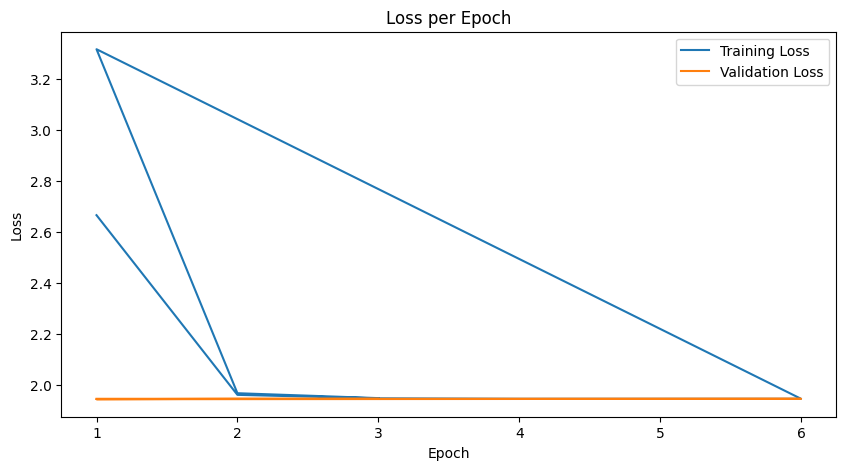

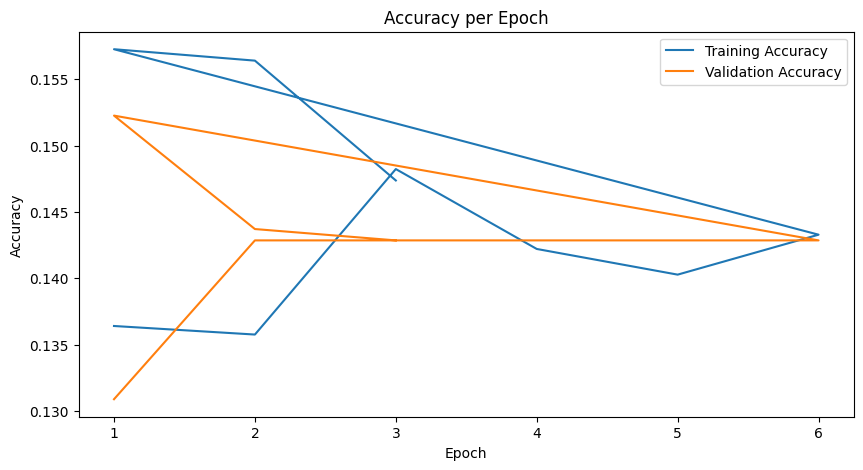

In [65]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["sparse_categorical_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 4: Test the model

In [ ]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{"cleaned_data_10-256_removed_stopwords_punc_num_space"}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

In [64]:
rawtext_test = ["i'm really nervous"]
# sequence_test = padding_func(tf.data.Dataset.from_tensors(tokenizer.tokenize(rawtext_test)))
predictions = classifier_model.predict(rawtext_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

ValueError: in user code:

    File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2436, in predict_function  *
        return step_function(self, iterator)
    File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2421, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2409, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2377, in predict_step
        return self(x, training=False)
    File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileqybjbdm9.py", line 10, in tf__call
        encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(preprocessed_text),), None, fscope)
    File "/tmp/__autograph_generated_filegdnlrw7_.py", line 74, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
    File "/tmp/__autograph_generated_filegdnlrw7_.py", line 72, in else_body_3
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)
    File "/tmp/__autograph_generated_filegdnlrw7_.py", line 72, in <lambda>
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)

    ValueError: Exception encountered when calling layer 'prediction' (type Classifier).
    
    in user code:
    
        File "/tmp/ipykernel_53854/2138391357.py", line 11, in call  *
            encoder_outputs = self.encoder(preprocessed_text)
        File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filegdnlrw7_.py", line 74, in tf__call
            ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
        File "/tmp/__autograph_generated_filegdnlrw7_.py", line 72, in else_body_3
            result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)
        File "/tmp/__autograph_generated_filegdnlrw7_.py", line 72, in <lambda>
            result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda: ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)
    
        ValueError: Exception encountered when calling layer 'keras_layer_3' (type KerasLayer).
        
        in user code:
        
            File "/home/ryanfikri/anaconda3/envs/capstone-bert/lib/python3.11/site-packages/tensorflow_hub/keras_layer.py", line 250, in call  *
                result = smart_cond.smart_cond(training,
        
            ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
              Positional arguments (3 total):
                * <tf.Tensor 'inputs:0' shape=(None,) dtype=string>
                * False
                * None
              Keyword arguments: {}
            
             Expected these arguments to match one of the following 4 option(s):
            
            Option 1:
              Positional arguments (3 total):
                * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
             'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
             'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
                * True
                * None
              Keyword arguments: {}
            
            Option 2:
              Positional arguments (3 total):
                * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
             'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
             'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
                * True
                * None
              Keyword arguments: {}
            
            Option 3:
              Positional arguments (3 total):
                * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
             'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
             'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
                * False
                * None
              Keyword arguments: {}
            
            Option 4:
              Positional arguments (3 total):
                * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
             'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
             'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
                * False
                * None
              Keyword arguments: {}
        
        
        Call arguments received by layer 'keras_layer_3' (type KerasLayer):
          • inputs=tf.Tensor(shape=(None,), dtype=string)
          • training=False
    
    
    Call arguments received by layer 'prediction' (type Classifier):
      • preprocessed_text=tf.Tensor(shape=(None,), dtype=string)


# Step 5: Done, save the model

In [ ]:
# Run this if you happy with the model
with open(data_dir+"/label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save(data_dir+'/second_iteration.keras')